# Schneider Electric European Hackathon

## **Team** : ThinkTank

| Member         | Contact | Github |
|----------------|---------|--------|
| Anton Chernysh | anton_chernysh@outlook.es  | https://github.com/Visn0 |
| Ramon Mateo    | mateo.trb@gmail.com  | https://github.com/MateoProjects |

## **Description**: 

The challenge consists of developing an image classification model in order to predict the type of deforestation in a satelital image. And the final goal of the model is to detect early the problem and perform actions to protect the lands. Apart from the satellite images, we have the coordinate of the image taken and its year.

To get the maximum score, the team participants have to present their code, the prediction results of their model and a presentation explaining the challenge, how they have approached the problem and why.

For this, our team has begun to carry out an analysis of the data to understand what correlation there may be with its type of deforestation. Subsequently, the first models have been made to see what the current state is, to see how complicated the task is and in order to have the first version of the complete flow. Finally, improvements have been made such as **DataAugmentation** and **TransferLearning** together with the validation of the results.

## 0.Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
import os
import random
import cv2
from skimage import io

In [2]:
!nvidia-smi

Sat Nov 19 19:12:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.Constants

In [3]:
DATA_PATH = 'drive/MyDrive/Schneider_hackaton/data/'
TRAIN_PATH= os.path.join(DATA_PATH, 'train.csv')
TEST_PATH = os.path.join(DATA_PATH, 'test.csv')
LABELS = ["Plantation", "Grassland/Shrubland", "Smallholder Agriculture"]
NUM_LABELS = len(LABELS)

In [4]:
# TO SAVE INTERMEDIATE DATASETS OR MODELS
import pickle
from os.path import join

def save_pickle(dir, filename, data):
  """
  Store data on the directory as a pickle file
  @param dir: directory 
  @param filename: name of file
  @data data: data that will be stored
  """
  pickle_out = open( join(dir, f'{filename}.pckl'), 'wb')
  pickle.dump(data, pickle_out)
  pickle_out.close()

def load_pickle(dir, filename):
  """
  Load pickle file
  @param dir: directory of file
  @param filename: filename of file to load
  """
  pickle_in = open( join(dir, f'{filename}.pckl'), 'rb' )
  data = pickle.load(pickle_in)
  pickle_in.close()
  return data

## 2.Load Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')
!ls $DATA_PATH

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
test.csv   train_test_data  X_val.pckl	  y_val.pckl
train.csv  X_train.pckl     y_train.pckl


In [6]:
def load_data(path, title):
  """
  Load csv file
  @param path: path of file
  @param title: Title to print
  """
  df = pd.read_csv(path)  
  df.rename(columns={"example_path":"path"}, inplace=True)

  print(f"=== df {title} ===")
  print(f"Image Shape: {df.shape}")  
  print(f"Missing Values: {df.isna().sum().sum()}")

  return df

df = load_data(TRAIN_PATH, "train")
df["path"] = df["path"].apply(lambda p: os.path.join(DATA_PATH, p))

df_test = load_data(TEST_PATH, "test")
df_test["path"] = df_test["path"].apply(lambda p: os.path.join(DATA_PATH, p))

=== df train ===
Image Shape: (1714, 5)
Missing Values: 0
=== df test ===
Image Shape: (635, 4)
Missing Values: 0


In [ ]:
df.head()

,label,latitude,longitude,year,path
0,0,-2.051853,111.826093,2001,drive/MyDrive/Schneider_hackaton/data/train_te...
1,2,-1.989349,105.309496,2013,drive/MyDrive/Schneider_hackaton/data/train_te...
2,0,1.223256,100.702217,2014,drive/MyDrive/Schneider_hackaton/data/train_te...
3,0,-2.342948,103.890226,2008,drive/MyDrive/Schneider_hackaton/data/train_te...
4,0,-0.126555,101.758175,2011,drive/MyDrive/Schneider_hackaton/data/train_te...


In [ ]:
df_test.head()

,latitude,longitude,year,path
0,0.761681,122.755954,2006,drive/MyDrive/Schneider_hackaton/data/train_te...
1,-8.059785,113.053791,2007,drive/MyDrive/Schneider_hackaton/data/train_te...
2,-2.006610,111.746316,2002,drive/MyDrive/Schneider_hackaton/data/train_te...
3,0.901765,114.042495,2016,drive/MyDrive/Schneider_hackaton/data/train_te...
4,1.911210,100.829633,2008,drive/MyDrive/Schneider_hackaton/data/train_te...


Image size:  332


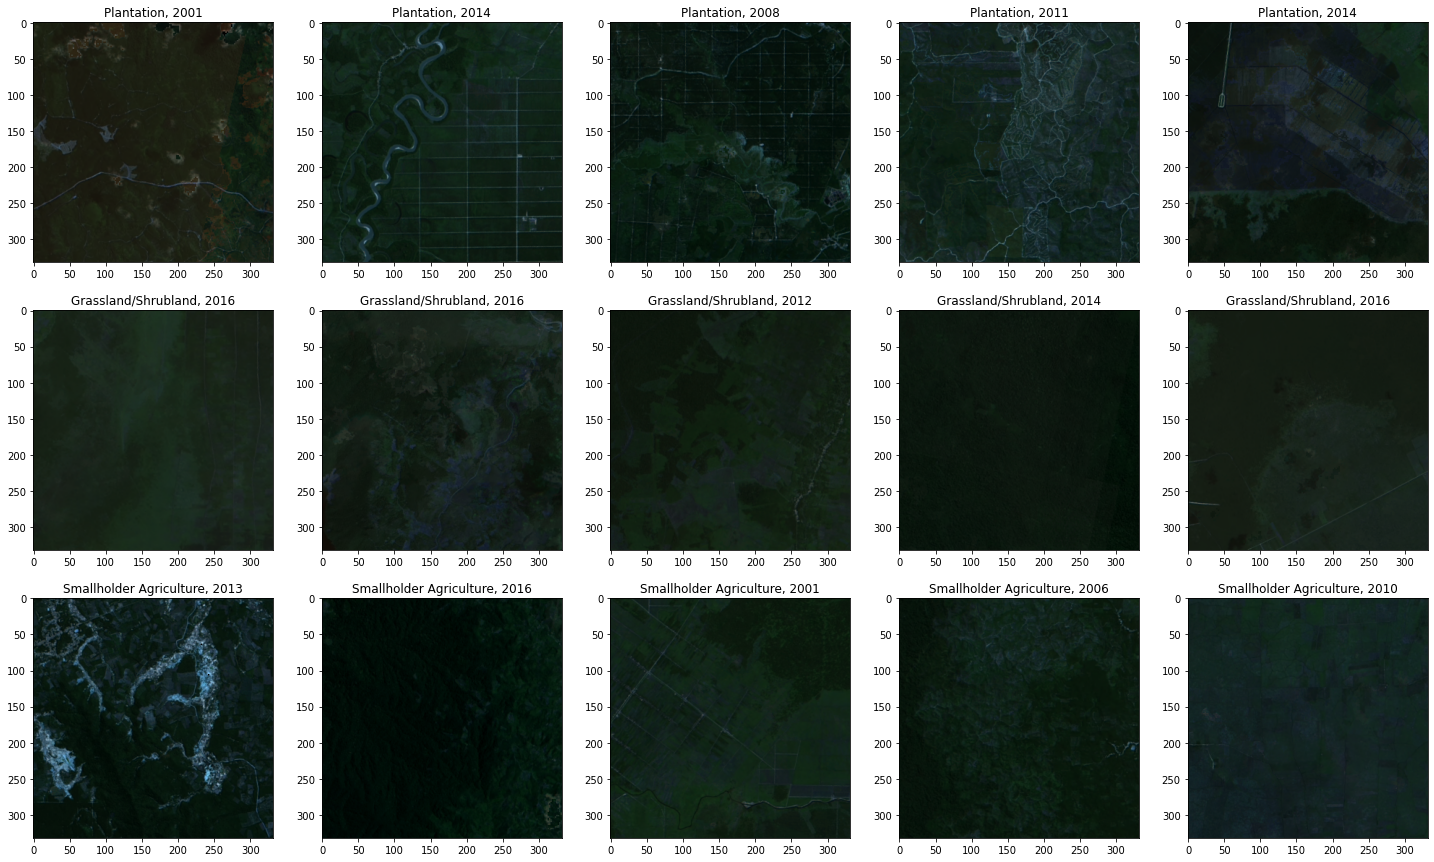

In [7]:
from keras.layers import Rescaling

def get_image(path):
  """
  Load image from path
  @param path: path where image is located
  @return : image
  """
  img = cv2.imread(path)
  # img = Rescaling(1./255)(img)
  return img

def plot_df(df, numImg):
  """
  Plot images 
  @param df: dataframe with paths of images
  @param numImg: Total images to be ploted
  """
  fig, axs = plt.subplots(NUM_LABELS, numImg, figsize=(5*numImg, 5*NUM_LABELS))
  for l in range(NUM_LABELS):
    
    for i, (idx, row) in enumerate(df.loc[df["label"]==l].head(numImg).iterrows()):
      # print(row.path)
      img = get_image(row["path"])
      axs[l][i].imshow(img);

      label = LABELS[row["label"]]
      year = row["year"]
      lon, lat = row["latitude"], row["longitude"]
      axs[l][i].set_title(f'{label}, {year}')

plot_df(df, 5)
img_shape = get_image(df["path"][0]).shape
IMG_SIZE = img_shape[0]
print("Image size: ", IMG_SIZE)

## 3.Analisis



### Histogram

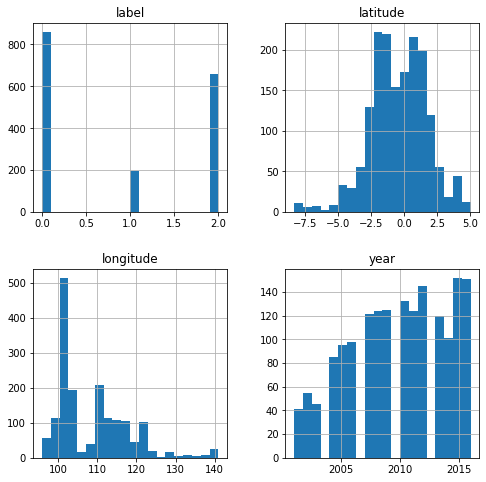

In [ ]:
_ = df.hist(bins=20, figsize=(8, 8))

### Correlation

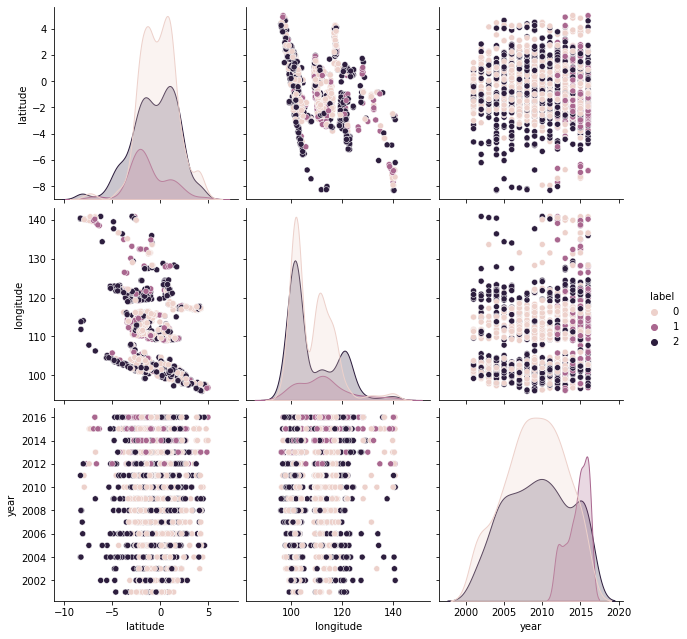

In [56]:
sns.pairplot(df, hue="label", height=3)

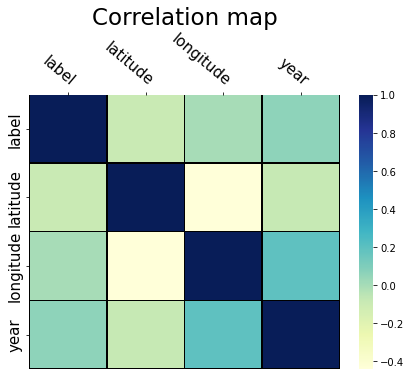

In [57]:
def correlation(df):
    corr_mat = df.corr(method='pearson', min_periods=1)

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5, linecolor='black')
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 15)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 15)
    ax.tick_params(top=True, bottom=False,
                    labeltop=True, labelbottom=False)
    plt.setp(ax.get_xticklabels(), rotation=-40, ha="right",
                rotation_mode="anchor")

    # ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    fig.tight_layout()
    ax.set_title('Correlation map', fontsize=23)
    plt.show()

correlation(df)

### Principal Component Analysis

In [58]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, RobustScaler
from sklearn.pipeline import make_pipeline

(1371, 3) (343, 3)
(1371,) (343,)


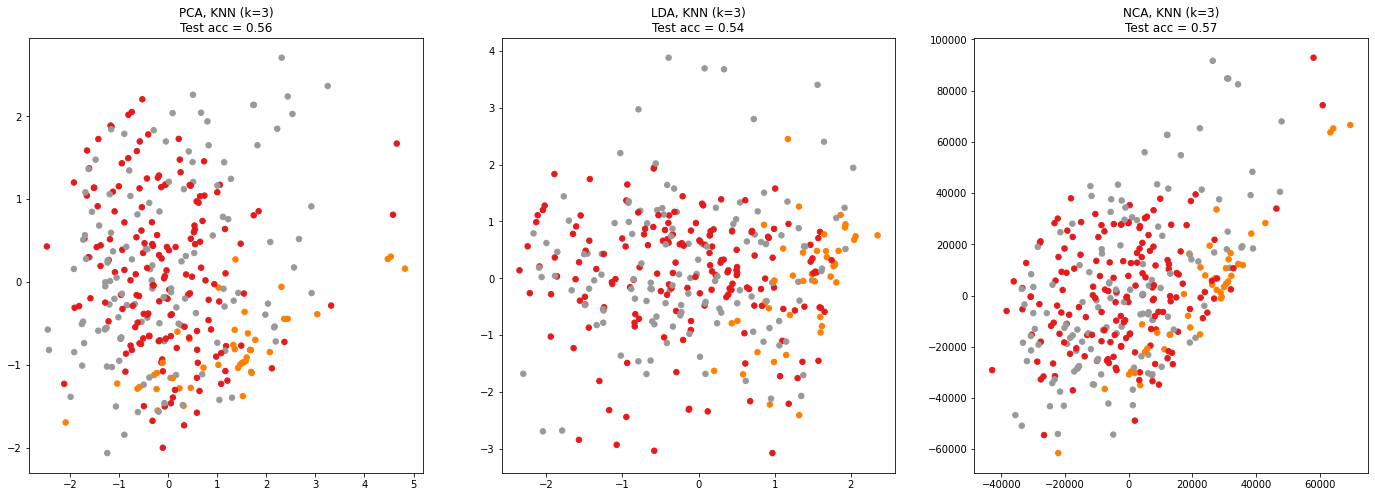

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [59]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# X = df["img"].to_numpy()
# X = np.asarray([x for x in X])
X = df[['latitude','longitude', 'year']].to_numpy()
y = df["label"].to_numpy()
y = np.asarray([a for a in y])
#y = to_categorical(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

random_state = 0

pca = make_pipeline(
    StandardScaler(), 
    PCA(n_components=2, random_state=random_state)
)
lda = make_pipeline(
    StandardScaler(), 
    LinearDiscriminantAnalysis(n_components=2)
)
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
)

knn = KNeighborsClassifier(n_neighbors=NUM_LABELS)
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]

fig, axs = plt.subplots(1, 3, figsize=(8*3, 8))
for i, (name, model) in enumerate(dim_reduction_methods):
  plt.figure()

  model.fit(X_train, y_train)
  knn.fit(model.transform(X_train), y_train)

  X_pred = model.transform(X_val)
  acc_knn = knn.score(X_pred, y_val)

  _ = axs[i].scatter(X_pred[:, 0], X_pred[:, 1], c=y_val, s=30, cmap="Set1")
  _ = axs[i].title.set_text("{}, KNN (k={})\nTest acc = {:.2f}".format(name, NUM_LABELS, acc_knn))
plt.show()

## 4.Preprocessing

In [8]:
# See each label percentage respective total amount
label_count = df["label"].value_counts()
df_size = len(df)
label_pct = [label_count[0]/df_size, label_count[1]/df_size, label_count[2]/df_size]

print(label_count, label_pct)

0    860
2    658
1    196
Name: label, dtype: int64 [0.5017502917152858, 0.11435239206534423, 0.3838973162193699]


In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X = df["path"].to_numpy()
X = np.asarray([x for x in X])
# X = df[['path', 'latitude', 'longitude', 'year']].to_numpy()
y = df["label"].to_numpy()
y = np.asarray([a for a in y])
y = to_categorical(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(1371,) (343,)
(1371, 3) (343, 3)


### Data augmentation

In [12]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import random

## Failed transformations
# tf.image.stateless_random_hue(img, max_delta=0.1, seed=seed))
# tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=30, max_jpeg_quality=90, seed=seed))
# tf.image.stateless_random_saturation(img, lower=0.5, upper=0.9, seed=seed))
# tf.image.stateless_random_brightness(img, max_delta=0.1, seed=seed))

def augment_with_balanced(path, label, seed, img_balance_pct):
  img = get_image(path)#/255.0
  images = []

  images.append(img);

  # Small pct need 100% probability of augmentation
  if img_balance_pct < 0.2:
    images.append(tf.image.stateless_random_flip_left_right(img, seed=seed));
    images.append(tf.image.stateless_random_flip_up_down(img, seed=seed));
    images.append(tf.image.stateless_random_flip_up_down(images[1], seed=seed));
    images.append(tf.image.stateless_random_contrast(img, lower=0.7, upper=1, seed=seed));
    images.append(tf.image.stateless_random_contrast(images[1], lower=0.7, upper=1, seed=(1, 5)));
    images.append(tf.image.stateless_random_contrast(images[2], lower=0.7, upper=1, seed=(1, 5)));

  # Depending the category balance it will have more or less probability to generate new images
  else:
    r = random.random()
    if r > img_balance_pct:
      images.append(tf.image.stateless_random_flip_left_right(img, seed=seed));
      
      r = random.random()
      if r > img_balance_pct:
        images.append(tf.image.stateless_random_flip_up_down(img, seed=seed));

        r = random.random()
        if r > img_balance_pct:
          images.append(tf.image.stateless_random_contrast(img, lower=0.7, upper=1, seed=seed));
          
          r = random.random()
          if r > img_balance_pct:
            images.append(tf.image.stateless_random_contrast(images[-2], lower=0.7, upper=1, seed=(1, 5)));
        


  return images, np.array([label]*len(images))

def augment_without_balanced(path, label, seed, img_balance_pct):
  img = get_image(path)#/255.0
  images = []

  images.append(img);
  images.append(tf.image.stateless_random_flip_left_right(img, seed=seed));
  images.append(tf.image.stateless_random_flip_up_down(img, seed=seed));
  images.append(tf.image.stateless_random_flip_up_down(images[1], seed=seed));
  images.append(tf.image.stateless_random_contrast(img, lower=0.7, upper=1, seed=seed));
  images.append(tf.image.stateless_random_contrast(images[1], lower=0.7, upper=1, seed=(1, 5)));
  images.append(tf.image.stateless_random_contrast(images[2], lower=0.7, upper=1, seed=(1, 5)));
  
  return images, np.array([label]*len(images))

In [13]:
%%time
total_aug_images = []
total_aug_labels = []
total_aug_names = []

for i in range(len(X_train)):
  category_balance = label_pct[np.argmax(y_train[i])]
  aug_images, aug_labels = augment_with_balanced(X_train[i], y_train[i], (1, 2), img_balance_pct=category_balance)
  name = X_train[i].split("/")[-1].split(".")[0]
  names = [name + str(j) + ".png" for j in range(len(aug_images))]

  if len(total_aug_images) == 0:
    total_aug_images = aug_images
    total_aug_labels = aug_labels
    total_aug_names = names
  else:
    total_aug_images = total_aug_images + aug_images
    total_aug_labels = np.append(total_aug_labels, aug_labels, axis=0)
    total_aug_names = total_aug_names + names

total_aug_images = np.asarray(total_aug_images)

print(len(total_aug_images) == len(total_aug_names), len(total_aug_images) == len(total_aug_labels))
print(total_aug_labels.shape)
print(total_aug_images.shape)

True True
(3650, 3)
(3650, 332, 332, 3)
CPU times: user 10.6 s, sys: 1.65 s, total: 12.3 s
Wall time: 16.7 s


(array([1361.,    0.,    0.,    0.,    0., 1064.,    0.,    0.,    0.,
        1225.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

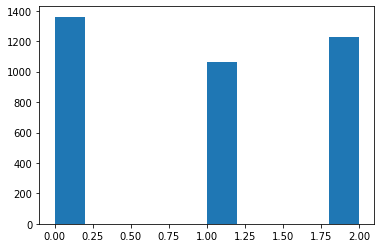

In [14]:
plt.hist(np.argmax(total_aug_labels, axis=1))

In [15]:
%%time
total_val_images = []

for i in range(len(X_val)):
  total_val_images.append(get_image(X_val[i]))#/255.0)
total_val_images = np.asarray(total_val_images)
print(y_val.shape)
print(total_val_images.shape)

(343, 3)
(343, 332, 332, 3)
CPU times: user 1.56 s, sys: 136 ms, total: 1.69 s
Wall time: 2.53 s


In [16]:
print(len(total_aug_images))
print(len(total_val_images))

3650
343


## 5.Training

### Data Generator

In [ ]:

class DataGenerator(Sequence):
  """Generates data for Keras
  Sequence based data generator. Suitable for building data generator for training and prediction.
  """

  def __init__(self, x_names, y_names, batch_size, istraining=False):
    
    self.x_values = x_names.copy()
    self.y_values =   y_names.copy()
    self.num_imgs = len(x_names)
    self.batch_size = batch_size
    self.training = istraining

  def __len__(self):
    """Denotes the number of batches per epoch
    :return: number of batches per epoch
    """
    return int(np.floor(self.num_imgs / self.batch_size))

  def __getitem__(self, index):
    """Generate one batch of data
    :param index: index of the batch
    :return: X and y when fitting. X only when predicting
    """
    # Generate indexes of the batch
    indexes = list(range(index * self.batch_size, (index + 1) * self.batch_size))

    # Generate data
    X = self._generate_X(indexes)
    y = self._generate_y(indexes)
    return X, y
      
  def _generate_X(self, indexes):
    # Initialization
    X = [] #np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3))

    for i, idx in enumerate(indexes):
      img = get_image(self.x_values[idx])
      if istraining:
        

      # X.append(get_image(self.x_values[idx]))

    X = np.array(X)
    return X

  def _generate_y(self, indexes):
    """Generates data containing batch_size masks
    :param list_IDs_temp: list of label ids to load
    :return: batch if masks
    """
    y = [] #np.empty((self.batch_size, NUM_LABELS))

    # Generate data
    for i, idx in enumerate(indexes):
      # Store sample
      # y[i,] = self.y_values[idx]
      y.append(self.y_values[idx])

    y = np.array(y)
    return y

### Models

In [17]:
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from skimage.transform import rotate, rescale
from keras.models import Sequential, Model
!pip install tensorflow_addons
import tensorflow_addons as tfa



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from tensorflow.keras import layers

NUM_LABELS = df["label"].nunique()
print(NUM_LABELS)

def get_vgg16(img_width, img_height):
  """ 
  VGG16 for image classification 
  @return Return vgg16 model with additional layers
  """
  from tensorflow.keras.applications.vgg16 import VGG16
  model = VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
  #model.trainable = True
  for layer in model.layers[:5]:
    layer.trainable = False

  #Adding custom Layers 
  x = model.output
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(2048, activation="relu")(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(516, activation="relu")(x)
  predictions = keras.layers.Dense(NUM_LABELS, activation="softmax")(x)

  model = Model(model.input, predictions) 
  return model

def get_resnet50(img_width, img_height):
  """ 
  ResNet50 for image classification 
  @return resnet model from keras
  """
  from tensorflow.keras.applications.resnet50 import ResNet50
  res_model = ResNet50(weights="imagenet", include_top=False, input_shape = (img_width, img_height, 3))
  print(len(res_model.layers))
  for layer in res_model.layers[:140]:
    layer.trainable = False

  model = keras.models.Sequential()
  model.add(res_model)
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(32, activation="relu"))
  model.add(keras.layers.Dense(NUM_LABELS, activation='softmax'))

  print(model.summary())
  return model

def get_efB0(img_width, img_height):
  """
  Get EfficientNetB0
  Return Model EfficientNetB0 with additional layers
  """
  from tensorflow.keras.applications import EfficientNetB0
  ef_model = EfficientNetB0(include_top=False,  input_shape =(img_width, img_height, 3))
  for layer in ef_model.layers[:50]:
    layer.trainable = False
  model = keras.models.Sequential()
  model.add(ef_model)
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(NUM_LABELS, activation='softmax'))
  print(model.summary())
  return model

def get_efB1(img_width, img_height):
  """
  Get EfficientNetB1
  Return Model EfficientNetB0 with additional layers
  """
  from tensorflow.keras.applications import EfficientNetB1
  ef_model = EfficientNetB1(include_top=True,  input_shape =(img_width, img_height, 3), classes=NUM_LABELS)
  model = keras.models.Sequential()
  model.add(ef_model)
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(NUM_LABELS, activation='softmax'))
  print(model.summary())
  return model

def custom_model():
  """
  Custom Model
  """
  from keras import layers
  model = Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_LABELS)
  ])
  return model

def get_resnet50_WithTabularData(img_width, img_height):
  """ 
  ResNet50 for image classification 
  @return resnet model from keras
  """
  from tensorflow.keras.layers import Input
  from tensorflow.keras.applications.resnet50 import ResNet50
  #inpImg = Input(shape=(img_width, img_height, 3))
  #model = keras.models.Sequential()
  #model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
  input1 = layers.Input(shape=(img_width, img_height, 3))
  res_model = ResNet50(weights="imagenet", include_top=False, input_shape=(img_width, img_height,3))
  for layer in res_model.layers[:130]:
    layer.trainable = False
  
  model = res_model(input1)
  model = layers.Flatten()(model)
  #model1 = Model(input1, model)

  input_2 = tf.keras.layers.Input(shape=(3,))
  dense_2 = tf.keras.layers.Dense(5, activation=tf.keras.activations.relu)(input_2)
  #model2 = Model(input_2, dense_2)

  #concat = tf.keras.layers.Concatenate()([model1, model2])
  concat = layers.concatenate([model, dense_2])
  output = tf.keras.layers.Dense(units=NUM_LABELS, activation="softmax")(concat)

  model = tf.keras.Model(inputs=[input1, input_2], outputs=[output])

  print(model.summary())
  return model

models = {"resnet50": get_resnet50, "vgg16": get_vgg16, 'EfficientNetB0': get_efB0, 'EfficientNetB1': get_efB1}

3


175
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 11, 11, 2048)      23587712  
                                                                 
 flatten_3 (Flatten)         (None, 247808)            0         
                                                                 
 dropout_3 (Dropout)         (None, 247808)            0         
                                                                 
 dense_3 (Dense)             (None, 32)                7929888   
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 31,517,699
Trainable params: 22,908,035
Non-trainable params: 8,609,664
_________________________________________________________________
None


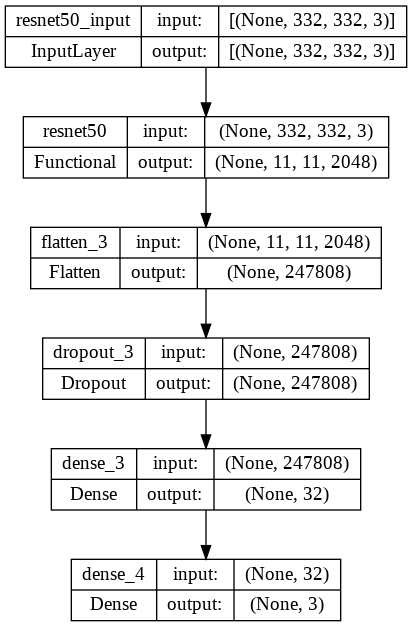

In [27]:
model_example = get_resnet50(IMG_SIZE, IMG_SIZE)

tf.keras.utils.plot_model(model_example,show_shapes=True)

In [28]:
%%time
model_name = "resnet50" # ["resnet50", "vgg16", "EfficientNetB0", "EfficientNetB1"]
EPOCHS = 20 
BATCHSIZE = 32  

# Model
model = models[model_name](IMG_SIZE, IMG_SIZE)

# Train params
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8,verbose=2,mode="auto",restore_best_weights=True)
metric_f1 =  tfa.metrics.F1Score(NUM_LABELS, average='macro', name='f1_score')

# Fit
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', metric_f1])
history = model.fit(total_aug_images, total_aug_labels, 
                    validation_data = (total_val_images, y_val), epochs = EPOCHS, batch_size=BATCHSIZE, callbacks = [early_stopping], verbose=1)

175
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 11, 11, 2048)      23587712  
                                                                 
 flatten_4 (Flatten)         (None, 247808)            0         
                                                                 
 dropout_4 (Dropout)         (None, 247808)            0         
                                                                 
 dense_5 (Dense)             (None, 32)                7929888   
                                                                 
 dense_6 (Dense)             (None, 3)                 99        
                                                                 
Total params: 31,517,699
Trainable params: 22,908,035
Non-trainable params: 8,609,664
_________________________________________________________________
None
Epoch 1/20
115/115 [=====

### Analysis

11/11 [==============================] - 3s 199ms/step


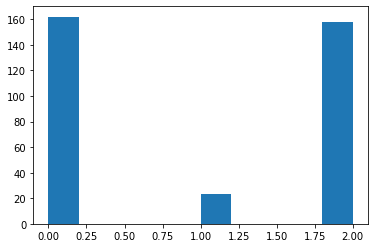

In [29]:
# Show prediction histogram in order to find any issues
val_pred = model.predict(total_val_images)
val_pred = np.round(val_pred)

_ = plt.hist(np.argmax(val_pred, axis=1))

In [30]:
# F1 score
from sklearn.metrics import f1_score

val_pred = np.argmax(val_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

f1_score( y_true, val_pred, average="macro")

0.7113407910661554

### History Plot


In [ ]:
def plot_learning_curves(history, title):
  """Plots the learning curve of the kfolds
  """
  fig = plt.figure(figsize=(20, 4))
  start_epoch = 0 #first epocs are too big
  # Loss plots
  ax1 = fig.add_subplot(1, 3, 1)
  ax1.set_title('Loss')
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(history['loss'][start_epoch:], color='blue', label='train')
  ax1.plot(history['val_loss'][start_epoch:], color='orange', label='validation')

  if 'accuracy' in history.keys():
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title('accuracy')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('accuracy')
    ax2.plot(history['accuracy'][start_epoch:], color='blue', label='train')
    ax2.plot(history['val_accuracy'][start_epoch:], color='orange', label='validation')
  if 'f1_score' in history.keys():
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.set_title('f1_score')
    ax3.set_xlabel('epochs')
    ax3.set_ylabel('f1_score')
    ax3.plot(history['f1_score'][start_epoch:], color='blue', label='train')
    ax3.plot(history['val_f1_score'][start_epoch:], color='orange', label='validation')

  plt.subplots_adjust(top=0.85, bottom=0.10, left=0.05, right=0.95, hspace=0.5, wspace=0.40)

  plt.legend()
  plt.suptitle(title)
  plt.show()


In [ ]:
plot_learning_curves(history.history, "")

## 6.Training Final model

Prepare all train and test data

In [32]:
X = df["path"].to_numpy()
X = np.asarray([x for x in X])
y = df["label"].to_numpy()
y = np.asarray([a for a in y])
y = to_categorical(y)

X_test = df_test["path"].to_numpy()
X_test = np.asarray([x for x in X_test])

print(X.shape, X_test.shape)
print(y.shape)

(1714,) (635,)
(1714, 3)


Fetch all train images and do data augmentation and balancing

In [35]:
%%time
total_aug_images = []
total_aug_labels = []

for i in range(len(X)):
  category_balance = label_pct[np.argmax(y[i])]
  aug_images, aug_labels = augment_with_balanced(X[i], y[i], (1, 2), img_balance_pct=category_balance)

  if len(total_aug_images) == 0:
    total_aug_images = aug_images
    total_aug_labels = aug_labels
  else:
    total_aug_images = total_aug_images + aug_images
    total_aug_labels = np.append(total_aug_labels, aug_labels, axis=0)

total_aug_images = np.asarray(total_aug_images)

print("Does final data has same len:", len(total_aug_images) == len(total_aug_labels))
print("Labels shape:", total_aug_labels.shape)
print("Images array shape:", total_aug_images.shape)

Does final data has same len: True
Labels shape: (4555, 3)
Images array shape: (4555, 332, 332, 3)
CPU times: user 14.3 s, sys: 1.03 s, total: 15.3 s
Wall time: 21.5 s


Fetch images to predict

In [36]:
%%time
total_test_images = []

for i in range(len(X_test)):
  total_test_images.append(get_image(X_test[i]))

total_test_images = np.asarray(total_test_images)

print("Test images array shape:", total_test_images.shape)

Test images array shape: (343, 332, 332, 3)
CPU times: user 2.39 s, sys: 206 ms, total: 2.59 s
Wall time: 2min 27s


In [37]:
model = models[model_name](IMG_SIZE, IMG_SIZE)

# Train params
metric_f1 =  tfa.metrics.F1Score(NUM_LABELS, average='macro', name='f1_score')

# Fit
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy', metric_f1]
)
history = model.fit(total_aug_images, total_aug_labels, epochs = EPOCHS, batch_size=BATCHSIZE, verbose=1)

175
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 11, 11, 2048)      23587712  
                                                                 
 flatten_5 (Flatten)         (None, 247808)            0         
                                                                 
 dropout_5 (Dropout)         (None, 247808)            0         
                                                                 
 dense_7 (Dense)             (None, 32)                7929888   
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
Total params: 31,517,699
Trainable params: 22,908,035
Non-trainable params: 8,609,664
_________________________________________________________________
None
Epoch 1/20
143/143 [=====

SAVE FINAL MODEL

In [39]:
from tensorflow.keras.models import load_model
import pickle

def save_trained_model(fileName, theModel, trainHistory):
  if not os.path.exists(fileName):
    theModel.save(fileName)

  if not os.path.exists(fileName+'_history.pickle'):
    with open(fileName+'_history.pickle', 'wb') as file:
        pickle.dump(trainHistory, file)

def load_trained_model(fileName):
  model, history = None, None

  if os.path.exists(fileName):
    model = load_model(fileName)

  if os.path.exists(fileName+'_history.pickle'):
    with open(fileName+'_history.pickle', 'rb') as file:
      history = pickle.load(file)
    
  return model, history

save_trained_model(os.path.join(DATA_PATH,'finalmodel.h5'), model, history)
# finalmodel, model_history = load_trained_model(rootPath+'finalmodel.h5')

## 7.Submission

In [50]:
pred = model.predict(total_test_images)
pred = np.argmax(pred, axis=1)

11/11 [==============================] - 2s 206ms/step


(array([170.,   0.,   0.,   0.,   0.,  33.,   0.,   0.,   0., 140.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

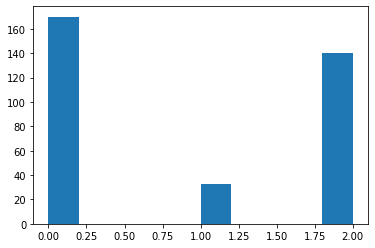

In [51]:
plt.hist(pred)

In [55]:
pd.DataFrame(pred, columns=["target"]).to_json(join(DATA_PATH, "predictions.json"), orient='columns')